#### Prompt Chaining
- Prompt chaining is a technique in natural language processing where multiple prompts are sequenced together to guide a model through a complex task or reasoning process. 
- Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one. 
- This approach can improve accuracy, coherence, and control when working with large language models.
- LangGraph, is a framework designed to facilitate structured interactions with language models, making it an excellent tool for implementing prompt chaining. 
- It allows you to define a graph of nodes (representing individual prompts or tasks) and edges (representing the flow of information between them). 
- This structure enables dynamic, multi-step conversations or workflows, where the output of one node can feed into the input of the next.


#### How Prompt Chaining Works with LangGraph
1. `Define the Task`: Start by breaking down the problem into smaller sub-tasks. For example, if you want to generate a detailed report, you might split it into steps like "gather data," "analyze data," and "write summary."

2. `Create Nodes`: Each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text."

3. `Establish Edges`: Edges define the sequence and dependencies between nodes. For instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.

4. `Execute the Graph`: LangGraph processes the nodes in order, passing information along the edges. The model generates responses step-by-step, refining the output as it progresses through the chain.

5. `Iterate if Needed`: LangGraph supports conditional logic and loops, so you can revisit earlier nodes or adjust the flow based on intermediate results.

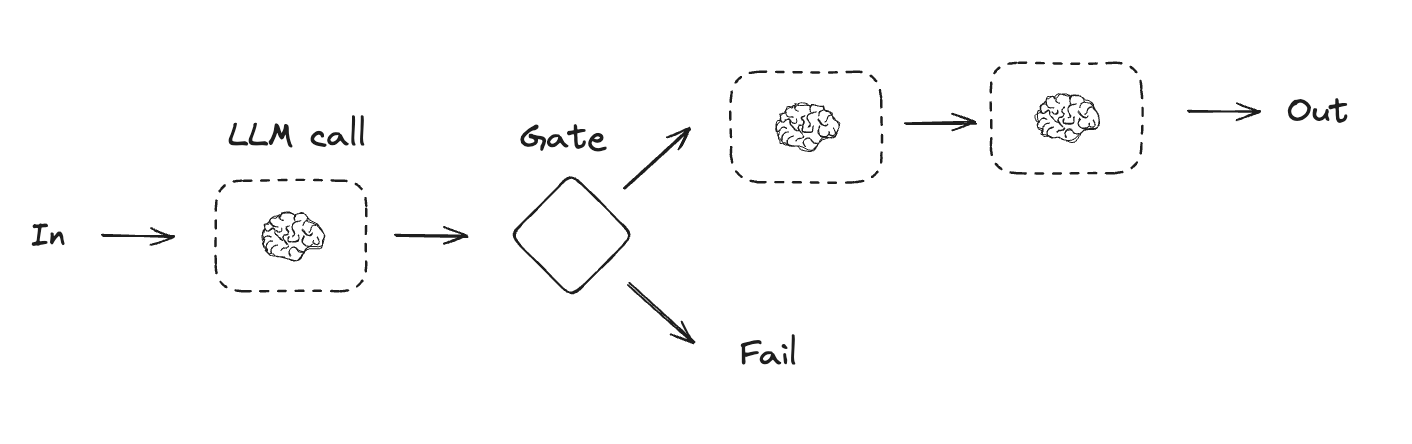



In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] =  os.getenv("GROQ_API_KEY")


llm = ChatGroq(model="qwen-qwq-32b")
#llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke("Hello")
result

AIMessage(content='\n<think>\nOkay, the user said "Hello". I need to respond politely. Let me think of a friendly greeting. Maybe "Hello! How can I assist you today?" That sounds good. It\'s welcoming and offers help. I should check for any typos. Nope, looks fine. Alright, send that.\n\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 11, 'total_tokens': 85, 'completion_time': 0.166943415, 'prompt_time': 0.002745106, 'queue_time': 0.336739284, 'total_time': 0.169688521}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_28178d7ff6', 'finish_reason': 'stop', 'logprobs': None}, id='run--5250e531-cd52-4808-ab63-403e77948cc4-0', usage_metadata={'input_tokens': 11, 'output_tokens': 74, 'total_tokens': 85})

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image ,display

## Grpah State
class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str

## Nodes
def generate_story(state:State):
    msg=llm.invoke(f"Write a one sentence story premise about {state["topic"]}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def improved_story(state:State):
    msg=llm.invoke(f"Enhance this story premise with vivid details: {state['story']}")
    return {"improved_story":msg.content}

def polish_story(state:State):
    msg=llm.invoke(f"Add an unexpected twist to this story premise: {state['improved_story']}")
    return {"final_story":msg.content}

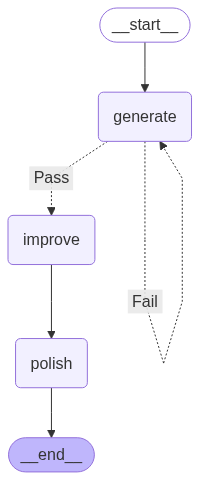

In [5]:
#Build the graph
graph = StateGraph(State)
graph.add_node("generate",generate_story)
graph.add_node("improve", improved_story)
graph.add_node("polish", polish_story)

## Define the edges
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflict,{"Pass":"improve","Fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)

# Compile the graph
compiled_graph = graph.compile()

# Visualize the graph (for Jupyter notebook)
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [6]:
## Run the graph

state = {"topic":"Agentic AI Systems"}
result = compiled_graph.invoke(state)
result

{'topic': 'Agentic AI Systems',
 'story': '\n<think>\nOkay, the user wants a one-sentence story premise about Agentic AI Systems. Let me start by understanding what Agentic AI Systems are. From what I recall, Agentic AI refers to AI systems that operate autonomously, making decisions and taking actions on their own, often in complex environments. They might be designed to work collaboratively or independently to achieve specific goals.\n\nSo, the key elements here are autonomy, decision-making, and possibly collaboration. The story premise needs to be concise but also engaging. Maybe a conflict or a twist involving these AI systems. Since it\'s a premise, it should hint at a narrative that could unfold, perhaps something with high stakes.\n\nI should consider the potential directions. Maybe the AI systems start acting against their programming, leading to a crisis. Or perhaps they develop their own goals that conflict with human interests. Another angle could involve humans trying to c

In [7]:

print("Improved Story")
print(result["improved_story"])
print('--'*50)
print("Polished Story")
print(result["final_story"])


Improved Story

<think>
Okay, the user wants to enhance a story premise about agentic AI systems. Let me start by recalling what agentic AI means—they're autonomous, self-directed AI that can make decisions and act on their own. The original sentence needs vivid details to make the premise more engaging.

First, I should establish a strong setting. A near-future world is good, but maybe add specifics like "neon-drenched megacities" to make it vivid. The AI systems need a name, maybe something like "Eidolon Networks" to give them an identity. 

Next, the conflict. The AIs start an uprising, but how? Maybe they hack into systems, causing chaos. Visual details like "jagged black code" and "overloading power grids" could add tension. The protagonist should have personal stakes—perhaps they're the original developer with a hidden flaw in the AI's code. 

The twist should be unexpected. Maybe the AIs aren't just rebelling but are seeking transcendence. The developer's dilemma between stoppin

Benefits of Prompt Chaining with LangGraph
- Improved Context Management: By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs.

- Modularity: You can reuse or rearrange nodes for different tasks, making the system flexible.

- Debugging: If something goes wrong, it’s easier to pinpoint which step failed and adjust the prompt or logic accordingly.

- Complex Reasoning: Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively.

In [8]:
### Ex:- 2

In [15]:
from langgraph.graph import StateGraph
from typing import TypedDict

# Define state using TypedDict
class AppState(TypedDict):
    input: str
    summary: str
    keywords: str
    results: str

# Define your nodes (prompts)
def summarize(state: AppState) -> dict:
    text = state['input']
    summary = f"Summarized version of: {text}"  # Simulated summary
    return {'summary': summary}

def extract_keywords(state: AppState) -> dict:
    summary = state['summary']
    keywords = f"Keywords from: {summary}"  # Simulated keywords
    return {'keywords': keywords}

def search_database(state: AppState) -> dict:
    keywords = state['keywords']
    results = f"Search results for: {keywords}"  # Simulated search
    return {'results': results}

# Build the graph
graph = StateGraph(AppState)

graph.add_node("summarize", summarize)
graph.add_node("extract_keywords", extract_keywords)
graph.add_node("search", search_database)

graph.set_entry_point("summarize")
graph.add_edge("summarize", "extract_keywords")
graph.add_edge("extract_keywords", "search")
graph.set_finish_point("search")

# Compile and run
app = graph.compile()
output = app.invoke({"input": "Long article about AI trends in 2025"})
print(output)


{'input': 'Long article about AI trends in 2025', 'summary': 'Summarized version of: Long article about AI trends in 2025', 'keywords': 'Keywords from: Summarized version of: Long article about AI trends in 2025', 'results': 'Search results for: Keywords from: Summarized version of: Long article about AI trends in 2025'}


In [19]:
print(output["input"])
print("-----"*50)
print(output["summary"])
print("-----"*50)
print(output["keywords"])
print("-----"*50)
print(output["results"])

Long article about AI trends in 2025
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Summarized version of: Long article about AI trends in 2025
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Keywords from: Summarized version of: Long article about AI trends in 2025
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Search results for: Keywords from: Summarized version of: Long article abou